In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.modflow_model import modflow_model

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from mpl_toolkits.axes_grid1 import make_axes_locatable

from collections import OrderedDict
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
config = {'font.family': 'Arial',
          'font.size': 13,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'mathtext.fontset': 'stix',
          'savefig.dpi': 300
         }
plt.rcParams.update(config)

def calculate_logk(nx, ny, mean_logk, lamda_xy, fn_x, fn_y, kesi):
    kesi = kesi.reshape(1, -1)
    logk = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            logk[iy, ix] = mean_logk + np.sum(np.sqrt(lamda_xy) * fn_x[ix][0] * fn_y[iy][0] * kesi.transpose())
    return logk

def forward_model(kesi, kle_data):
    nx, ny, mean_logk, lamda_xy, fn_x, fn_y, _ = kle_data
    logk = calculate_logk(nx, ny, mean_logk, lamda_xy, fn_x, fn_y, np.asarray(kesi))
    k = np.exp(logk)
    
    return k.reshape(nx, ny)

filename = "./output/case3/experiment_results_runs_50_saved.pkl"
try:
    with open(filename, 'rb') as f:
        results = pickle.load(f)
except FileNotFoundError:
    print(f"Error: The file '{filename}' was not found. Please make sure it's in the correct path.")
    exit()

ga_par_metrics = np.array(results['metrics_ga_par'])
sgts_par_metrics = np.array(results['metrics_sgts_par'])

perm_ga_runs = np.array(results['perm_ga_runs'])
perm_sgts_runs = np.array(results['perm_sgts_runs'])

best_kesi_ga_runs = np.array(results['best_kesi_ga_runs'])
best_kesi_sgts_runs = np.array(results['best_kesi_sgts_runs'])

true_kesi = results['true_parameters'].ravel()
n_runs = results['n_runs']
dims = results['dimensions']
nx, ny = dims['nx'], dims['ny']

data_path = "./data/KLE.npy"

kle_data = np.load(data_path, allow_pickle=True).tolist()

true_perm_field = forward_model(true_kesi, kle_data)

print("Results loaded successfully!")
print(f"Number of runs: {n_runs}")
print(f"Shape of a single inverted Kesi vector: {best_kesi_ga_runs[0].shape}")
print(f"Number of inverted Kesi parameters: {len(true_kesi)}")

# ---------------------------------------------------------------------
avg_kesi_ga = np.mean(best_kesi_ga_runs, axis=0)
std_kesi_ga = np.std(best_kesi_ga_runs, axis=0)

avg_kesi_sgts = np.mean(best_kesi_sgts_runs, axis=0)
std_kesi_sgts = np.std(best_kesi_sgts_runs, axis=0)

n_params = len(true_kesi)
x_indices = np.arange(n_params)

Results loaded successfully!
Number of runs: 50
Shape of a single inverted Kesi vector: (15,)
Number of inverted Kesi parameters: 15


c:\ProgramFiles\Miniconda\envs\work\Lib\site-packages\matplotlib_inline\config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


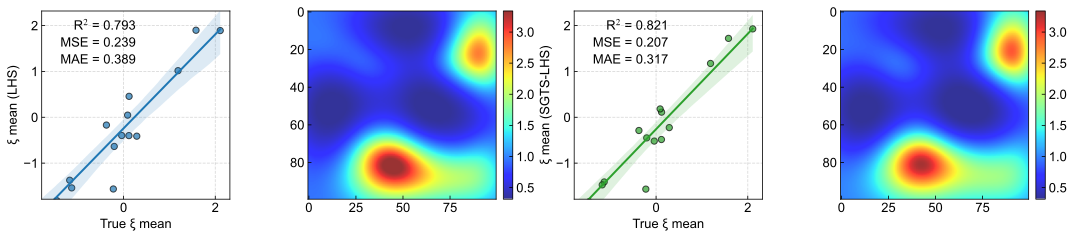

In [2]:
ga_mean   = best_kesi_ga_runs.mean(axis=0)
sgts_mean = best_kesi_sgts_runs.mean(axis=0)

fig, axes = plt.subplots(1, 4, figsize=(18, 4))

def plot_reg(ax, x, y, label, color):
    sns.regplot(
        x=x, y=y, ax=ax, ci=95, color=color,
        scatter_kws={'s':40,'alpha':0.7,'edgecolor':'black','facecolor':color},
        line_kws={'linewidth':2}
    )

    ax.text(0.50, 0.95, f'R$^2$ = {r2_score(x,y):.3f}',  transform=ax.transAxes, va='top', ha='right')
    ax.text(0.50, 0.86, f'MSE = {mean_squared_error(x,y):.3f}', transform=ax.transAxes, va='top', ha='right')
    ax.text(0.50, 0.77, f'MAE = {mean_absolute_error(x,y):.3f}', transform=ax.transAxes, va='top', ha='right')
    ax.set_ylabel(f'{label}')
    ax.grid(True, which='major', axis='both', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    ax.set_xlim(min(true_kesi.min(), x.min())*0.9, max(true_kesi.max(), x.max())*1.1)
    ax.set_ylim(min(true_kesi.min(), y.min())*0.9, max(true_kesi.max(), y.max())*1.1)
    ax.set_aspect('equal', adjustable='box')

plot_reg(axes[0], true_kesi, ga_mean, 'ξ mean (LHS)',   color='tab:blue')

divider0 = make_axes_locatable(axes[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cax0.axis('off')

im_ax = axes[1]
m = im_ax.imshow(np.mean(np.stack(perm_ga_runs),axis=0), cmap="jet", aspect="equal", alpha=0.8, vmin=true_perm_field.min(), vmax=true_perm_field.max())
divider1 = make_axes_locatable(im_ax)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
fig.colorbar(m, cax=cax1, orientation='vertical')

plot_reg(axes[2], true_kesi, sgts_mean, 'ξ mean (SGTS-LHS)', color='tab:green')

divider2 = make_axes_locatable(axes[2])
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cax2.axis('off')

im_ax2 = axes[3]
m2 = im_ax2.imshow(np.mean(np.stack(perm_sgts_runs),axis=0), cmap="jet", aspect="equal", alpha=0.8, vmin=true_perm_field.min(), vmax=true_perm_field.max())
divider3 = make_axes_locatable(im_ax2)
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
fig.colorbar(m2, cax=cax3, orientation='vertical')

axes[0].set_xlabel('True ξ mean')
axes[2].set_xlabel('True ξ mean')

plt.subplots_adjust(wspace=0.3)
plt.show()


C:\Users\wang\AppData\Local\Temp\ipykernel_29340\1014416516.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\wang\AppData\Local\Temp\ipykernel_29340\1014416516.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\wang\AppData\Local\Temp\ipykernel_29340\1014416516.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


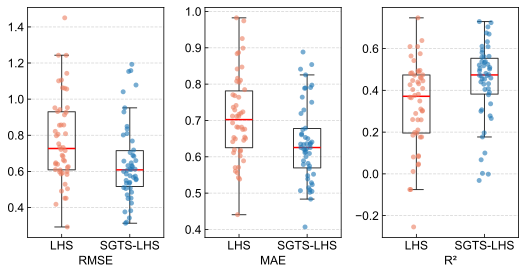

In [3]:
true_kesi = np.array(true_kesi)               # (15,)
ga = np.array(best_kesi_ga_runs)              # (42, 15)
sgts = np.array(best_kesi_sgts_runs)          # (42, 15)

mse_ga  = np.mean((ga   - true_kesi)**2, axis=1)    # (42,)
mae_ga  = np.mean(np.abs(ga   - true_kesi), axis=1) # (42,)
mse_sgts = np.mean((sgts - true_kesi)**2, axis=1)
mae_sgts = np.mean(np.abs(sgts - true_kesi), axis=1)

r2_ga   = np.array([r2_score(true_kesi, run) for run in ga])
r2_sgts = np.array([r2_score(true_kesi, run) for run in sgts])

metrics_to_plot = [
    {'data_b': mse_ga,   'data_s': mse_sgts, 'name': 'RMSE'},
    {'data_b': mae_ga,   'data_s': mae_sgts, 'name': 'MAE'},
    {'data_b': r2_ga,    'data_s': r2_sgts,  'name': 'R²'}
]

fig, axes = plt.subplots(1, 3, figsize=(7.5, 4))
custom_palette = ['#EB7E60', '#1f77b4', '#2ca02c']

palette = custom_palette[:2]

for ax, metric_info in zip(axes, metrics_to_plot):
    
    data_b = metric_info['data_b']
    data_s = metric_info['data_s']
    metric_name = metric_info['name']

    df_for_plot = pd.DataFrame({
        metric_name: np.concatenate([data_b, data_s]),
        'Method': ['LHS'] * len(data_b) + ['SGTS-LHS'] * len(data_s)
    })

    sns.boxplot(
        data=df_for_plot,
        x='Method',
        y=metric_name,
        ax=ax,
        showfliers=False,
        boxprops={'edgecolor': 'black', 'alpha': 0.8, 'facecolor': 'None'},
        whiskerprops={'color': 'black', 'alpha': 0.8},
        capprops={'color': 'black', 'alpha': 0.8},
        medianprops={'color': 'red', 'linewidth': 1.5},
        width=0.4,
    )

    sns.stripplot(
        data=df_for_plot,
        x='Method',
        y=metric_name,
        ax=ax,
        alpha=0.6,
        size=5,
        jitter=0.1,
        palette=palette
    )
    
    ax.grid(visible=True, which='major', axis='y', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    # ax.set_xlabel('Method', fontsize=13)
    ax.set_ylabel(None)
    ax.set_xlabel(metric_name, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

C:\Users\wang\AppData\Local\Temp\ipykernel_29340\2574323887.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\wang\AppData\Local\Temp\ipykernel_29340\2574323887.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(
C:\Users\wang\AppData\Local\Temp\ipykernel_29340\2574323887.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


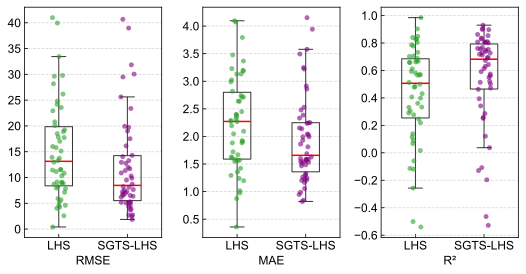

In [4]:
def acquire_obs(kesi):
    K_field = forward_model(kesi, kle_data)
    obs = np.array(modflow_model(K_field))
    return obs.ravel()

true_obs = acquire_obs(true_kesi)

ga_mse_obs = []
ga_mae_obs = []
ga_r2_obs = []
for i in range(best_kesi_ga_runs.shape[0]):
    temp_obs = acquire_obs(best_kesi_ga_runs[i])

    ga_mse_obs.append(mean_squared_error(true_obs, temp_obs))
    ga_mae_obs.append(mean_absolute_error(true_obs, temp_obs))
    ga_r2_obs.append(r2_score(true_obs, temp_obs))
ga_mse_obs = np.array(ga_mse_obs)
ga_mae_obs = np.array(ga_mae_obs)
ga_r2_obs  = np.array(ga_r2_obs)

sgts_mse_obs = []
sgts_mae_obs = []
sgts_r2_obs = []
for i in range(best_kesi_sgts_runs.shape[0]):
    temp_obs = acquire_obs(best_kesi_sgts_runs[i])

    sgts_mse_obs.append(mean_squared_error(true_obs, temp_obs))
    sgts_mae_obs.append(mean_absolute_error(true_obs, temp_obs))
    sgts_r2_obs.append(r2_score(true_obs, temp_obs))
sgts_mse_obs = np.array(sgts_mse_obs)
sgts_mae_obs = np.array(sgts_mae_obs)
sgts_r2_obs  = np.array(sgts_r2_obs)

metrics_to_plot = [
    {'data_b': ga_mse_obs,   'data_s': sgts_mse_obs, 'name': 'RMSE'},
    {'data_b': ga_mae_obs,   'data_s': sgts_mae_obs, 'name': 'MAE'},
    {'data_b': ga_r2_obs,    'data_s': sgts_r2_obs,  'name': 'R²'}
]

fig, axes = plt.subplots(1, 3, figsize=(7.5, 4))
custom_palette = ['#2ca02c', "purple"]

palette = custom_palette[:2]

for ax, metric_info in zip(axes, metrics_to_plot):
    
    data_b = metric_info['data_b']
    data_s = metric_info['data_s']
    metric_name = metric_info['name']

    df_for_plot = pd.DataFrame({
        metric_name: np.concatenate([data_b, data_s]),
        'Method': ['LHS'] * len(data_b) + ['SGTS-LHS'] * len(data_s)
    })

    sns.boxplot(
        data=df_for_plot,
        x='Method',
        y=metric_name,
        ax=ax,
        showfliers=False,
        boxprops={'edgecolor': 'black', 'alpha': 0.8, 'facecolor': 'None'},
        whiskerprops={'color': 'black', 'alpha': 0.8},
        capprops={'color': 'black', 'alpha': 0.8},
        medianprops={'color': 'red', 'linewidth': 1.5},
        width=0.4,
    )

    sns.stripplot(
        data=df_for_plot,
        x='Method',
        y=metric_name,
        ax=ax,
        alpha=0.6,
        size=5,
        jitter=0.1,
        palette=palette
    )
    
    ax.grid(visible=True, which='major', axis='y', alpha=0.5, linestyle='--')
    ax.set_axisbelow(True)
    ax.set_ylabel(None)
    ax.set_xlabel(metric_name, fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()

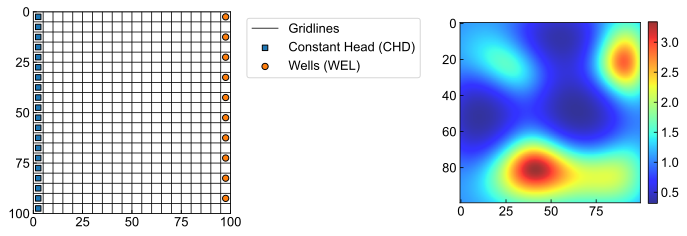

In [5]:
import numpy as np
import matplotlib.pyplot as plt

x_number = 20
y_number = 20

chd_col = np.full(y_number, 1)
chd_row = np.arange(1, y_number + 1)

chd_x_coords = chd_col - 0.5
chd_y_coords = chd_row - 0.5

wel_row = np.arange(1, y_number + 1, 2)
wel_col = np.full(len(wel_row), x_number)

wel_x_coords = wel_col - 0.5
wel_y_coords = wel_row - 0.5

fig, axes = plt.subplots(1,2, figsize=(11.25, 3.5))
ax = axes[0]

grid = np.arange(0, max(x_number, y_number) + 1, 1)
X, Y = np.meshgrid(grid, grid)
ax.plot(X, Y, linestyle='-', color='black', linewidth=0.8)
ax.plot(Y, X, linestyle='-', color='black', linewidth=0.8)
ax.plot([], [], linestyle='-', color='black', linewidth=0.8, label="Gridlines")

ax.scatter(chd_x_coords, chd_y_coords, 
           edgecolor="black", s=30, marker='s', label="Constant Head (CHD)")

ax.scatter(wel_x_coords, wel_y_coords, 
           edgecolor="black", s=40, marker='o', label="Wells (WEL)")

ax.set_xlim(0, x_number)
ax.set_ylim(0, y_number)

ax.invert_yaxis()

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

ax.set_xticks(np.arange(0, x_number + 1, 5))
ax.set_yticks(np.arange(0, y_number + 1, 5))
ax.set_xticklabels(np.arange(0, 101, 25))
ax.set_yticklabels(np.arange(0, 101, 25))
ax.tick_params(bottom=True, top=False, left=True, right=False,
               labelbottom=True, labeltop=False, labelleft=True, labelright=False)

# ax.set_xlabel("Column Index")
# ax.set_ylabel("Row Index")

plt.tight_layout(rect=[0, 0, 0.85, 1])

ax = axes[1]
m = ax.imshow(true_perm_field, cmap='jet', alpha=0.8)
cbar = fig.colorbar(m,
                    ax=ax,
                    fraction=0.046,
                    pad=0.04)
plt.show()